In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [3]:
res = 800
x_min, x_max = -2.5, 1.5
y_min, y_max = -2, 2
trap_center_real, trap_center_imag = 0.5, 0.0
trap_center = complex(trap_center_real, trap_center_imag)
trap_radius = 3.0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


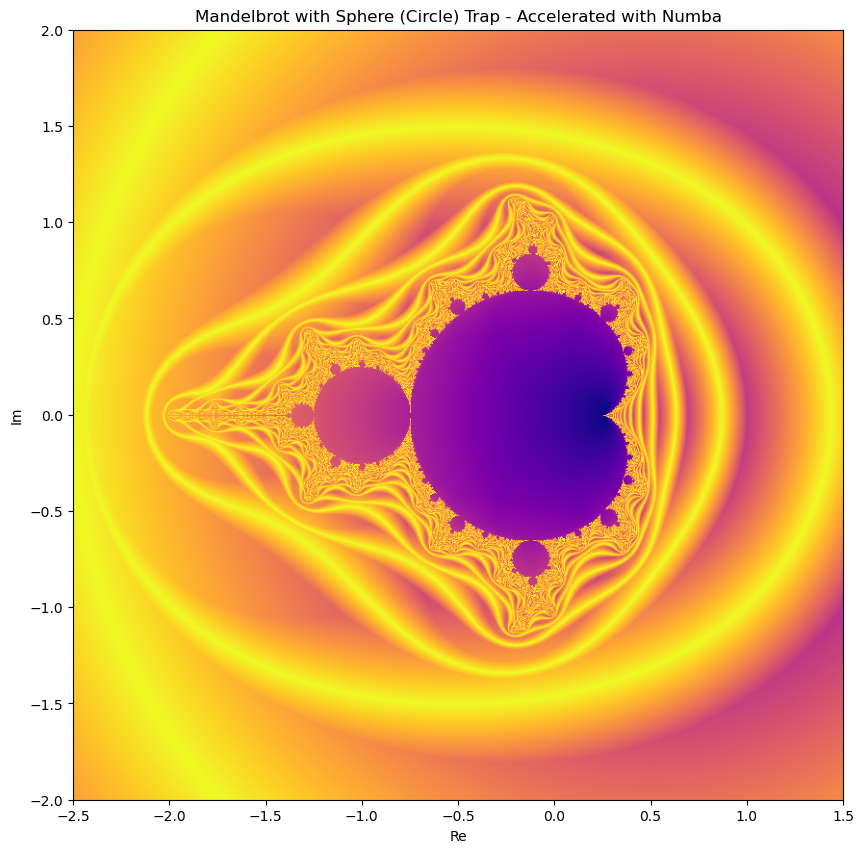

CPU times: user 1.35 s, sys: 575 ms, total: 1.93 s
Wall time: 825 ms


In [4]:
%%time

@numba.njit(parallel=True)
def mandelbrot_sphere_trap(x_min, x_max, y_min, y_max, width, height, max_iter, trap_center_real, trap_center_imag, trap_radius):
    trap_center = complex(trap_center_real, trap_center_imag)
    trap_dist = np.full((height, width), np.inf)
    mask = np.ones((height, width), dtype=np.bool_)
    Z = np.zeros((height, width), dtype=np.complex128)

    for i in range(max_iter):
        for y in numba.prange(height):
            for x in range(width):
                if mask[y, x]:
                    Z[y, x] = Z[y, x] * Z[y, x] + complex(
                        x_min + x * (x_max - x_min) / width,
                        y_min + y * (y_max - y_min) / height
                    )
                    dist = abs(abs(Z[y, x] - trap_center) - trap_radius)
                    if dist < trap_dist[y, x]:
                        trap_dist[y, x] = dist
                    if abs(Z[y, x]) >= 4:
                        mask[y, x] = False
    return trap_dist

# === Settings ===
width, height = res, res
#x_min, x_max = -2.5, 1.5
#y_min, y_max = -2, 2
max_iter = 300
#trap_center_real, trap_center_imag = 0.5, 0.0
#trap_radius = 3

# Compute the trap distances with JIT-accelerated function
trap_dist = mandelbrot_sphere_trap(x_min, x_max, y_min, y_max, width, height, max_iter,
                                   trap_center_real, trap_center_imag, trap_radius)

# Normalize for display
normalized = 1 - np.clip(trap_dist / trap_radius, 0, 1)

plt.figure(figsize=(10, 10))
plt.imshow(normalized, cmap='plasma', extent=(x_min, x_max, y_min, y_max))
plt.title("Mandelbrot with Sphere (Circle) Trap - Accelerated with Numba")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

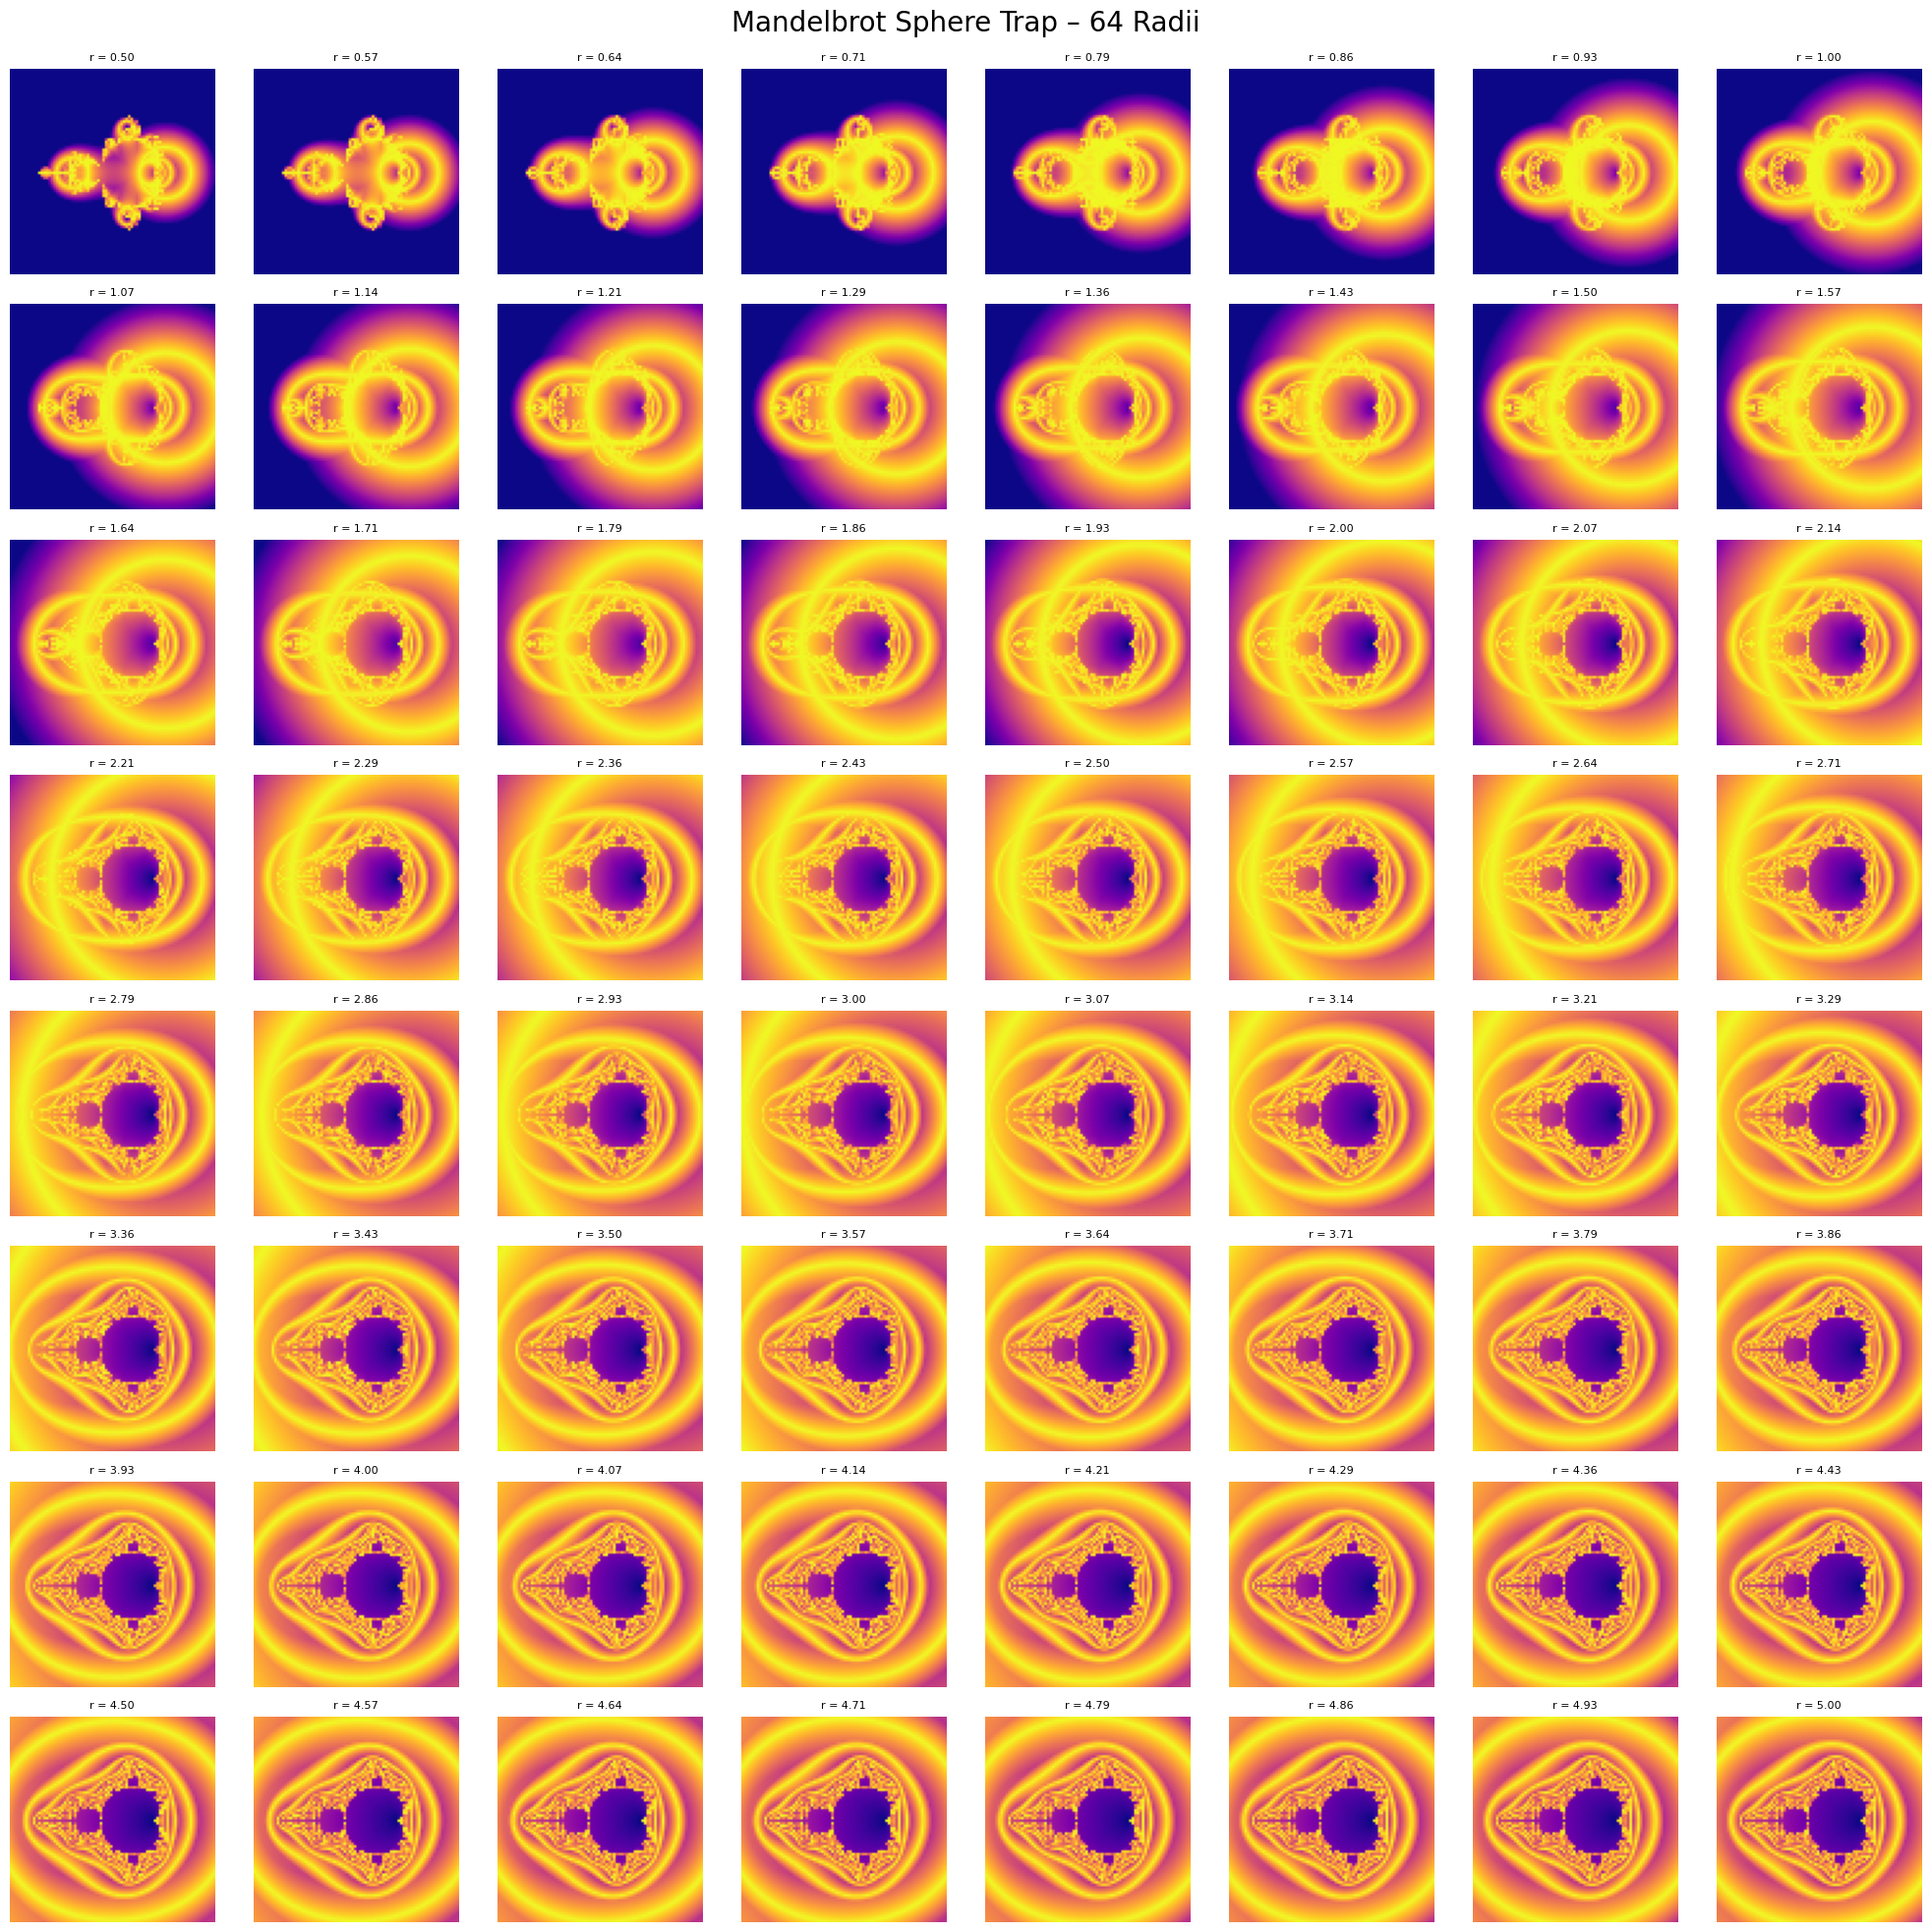

CPU times: user 4.45 s, sys: 1.7 s, total: 6.14 s
Wall time: 2.28 s


In [5]:
%%time

@numba.njit(parallel=True)
def mandelbrot_sphere_trap(x_min, x_max, y_min, y_max, width, height, max_iter,
                           trap_center_real, trap_center_imag, trap_radius):
    trap_center = complex(trap_center_real, trap_center_imag)
    trap_dist = np.full((height, width), np.inf)
    mask = np.ones((height, width), dtype=np.bool_)
    Z = np.zeros((height, width), dtype=np.complex128)

    for i in range(max_iter):
        for y in numba.prange(height):
            for x in range(width):
                if mask[y, x]:
                    Z[y, x] = Z[y, x] * Z[y, x] + complex(
                        x_min + x * (x_max - x_min) / width,
                        y_min + y * (y_max - y_min) / height
                    )
                    dist = abs(abs(Z[y, x] - trap_center) - trap_radius)
                    if dist < trap_dist[y, x]:
                        trap_dist[y, x] = dist
                    if abs(Z[y, x]) >= 4:
                        mask[y, x] = False
    return trap_dist

# === Settings ===
low_res = int(res / 10)  # Adjust as needed
width, height = low_res, low_res
#x_min, x_max = -2.5, 1.5
#y_min, y_max = -2, 2
max_iter = 300
#trap_center_real, trap_center_imag = 0.5, 0.0

# === Generate 64 different radii ===
radii = np.linspace(0.5, 5.0, 64)

# === Compute and collect results ===
results = []
for trap_radius in radii:
    trap_dist = mandelbrot_sphere_trap(x_min, x_max, y_min, y_max, width, height, max_iter,
                                       trap_center_real, trap_center_imag, trap_radius)
    normalized = 1 - np.clip(trap_dist / trap_radius, 0, 1)
    results.append(normalized)

# === Plot in an 8x8 grid ===
fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(results[i], cmap='plasma', extent=(x_min, x_max, y_min, y_max))
    ax.set_title(f"r = {radii[i]:.2f}", fontsize=8)
    ax.axis('off')

plt.suptitle("Mandelbrot Sphere Trap – 64 Radii", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


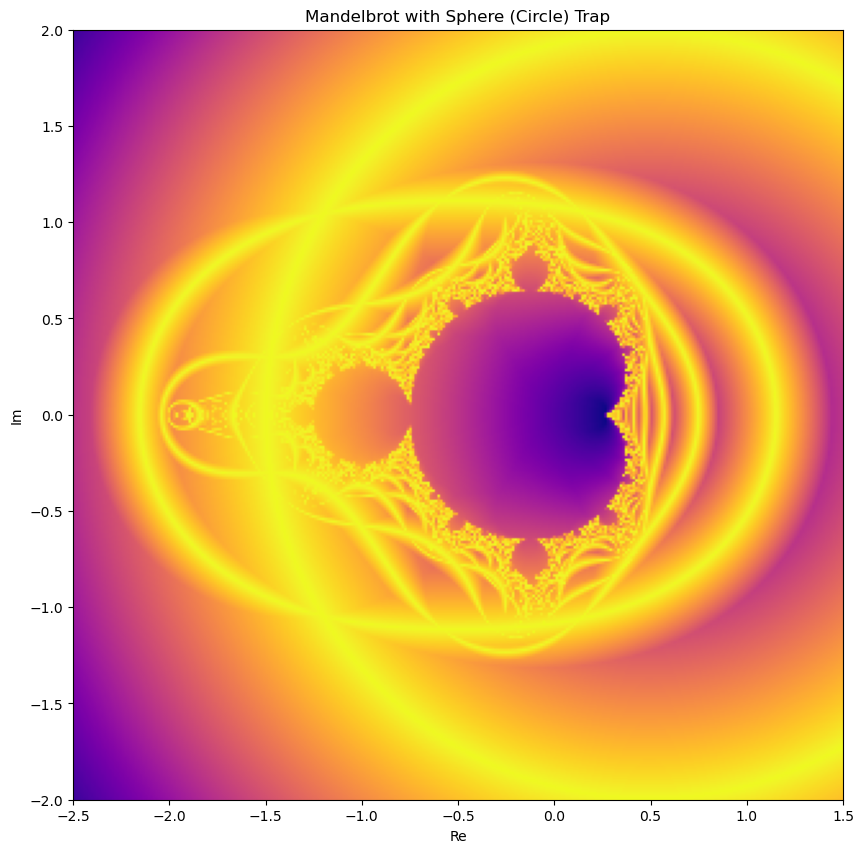

CPU times: user 301 ms, sys: 22.5 ms, total: 324 ms
Wall time: 323 ms


In [87]:
%%time

# === Image and domain settings ===
width, height = res, res
#x_min, x_max = -2.5, 1.5
#y_min, y_max = -2, 2
max_iter = 300

# === Create grid of complex points (c values) ===
x = np.linspace(x_min, x_max, width)
y = np.linspace(y_min, y_max, height)
X, Y = np.meshgrid(x, y)
C = X + 1j * Y

Z = np.zeros(C.shape, dtype=complex)
trap_dist = np.full(C.shape, np.inf)
mask = np.full(C.shape, True)

# === Sphere trap parameters ===
#trap_center = complex(0.5, 0.0)   # Change position here
#trap_radius = 3

for i in range(max_iter):
    Z[mask] = Z[mask]**2 + C[mask]

    # Distance from each point to the circle edge
    current_dist = np.abs(np.abs(Z - trap_center) - trap_radius)

    trap_dist = np.minimum(trap_dist, current_dist)

    mask &= (np.abs(Z) < 4)

# === Normalize for display ===
normalized = 1 - np.clip(trap_dist / trap_radius, 0, 1)

plt.figure(figsize=(10, 10))
plt.imshow(normalized, cmap='plasma', extent=(x_min, x_max, y_min, y_max))
plt.title("Mandelbrot with Sphere (Circle) Trap")
plt.xlabel("Re")
plt.ylabel("Im")
#plt.colorbar(label='Distance to sphere trap')
plt.show()

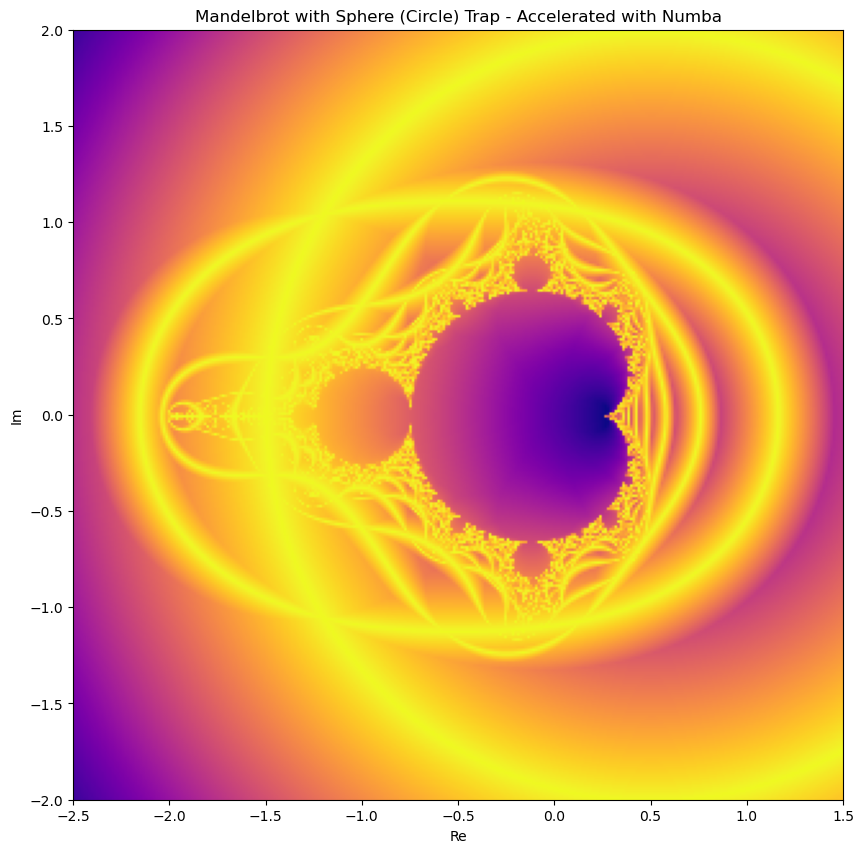

CPU times: user 1.5 s, sys: 379 ms, total: 1.88 s
Wall time: 470 ms


In [88]:
%%time

@numba.njit(parallel=True)
def mandelbrot_sphere_trap(x_min, x_max, y_min, y_max, width, height, max_iter, trap_center_real, trap_center_imag, trap_radius):
    trap_center = complex(trap_center_real, trap_center_imag)
    trap_dist = np.full((height, width), np.inf)
    mask = np.ones((height, width), dtype=np.bool_)
    Z = np.zeros((height, width), dtype=np.complex128)

    for i in range(max_iter):
        for y in numba.prange(height):
            for x in range(width):
                if mask[y, x]:
                    Z[y, x] = Z[y, x] * Z[y, x] + complex(
                        x_min + x * (x_max - x_min) / width,
                        y_min + y * (y_max - y_min) / height
                    )
                    dist = abs(abs(Z[y, x] - trap_center) - trap_radius)
                    if dist < trap_dist[y, x]:
                        trap_dist[y, x] = dist
                    if abs(Z[y, x]) >= 4:
                        mask[y, x] = False
    return trap_dist

# === Settings ===
width, height = res, res
#x_min, x_max = -2.5, 1.5
#y_min, y_max = -2, 2
max_iter = 300
#trap_center_real, trap_center_imag = 0.5, 0.0
#trap_radius = 3

# Compute the trap distances with JIT-accelerated function
trap_dist = mandelbrot_sphere_trap(x_min, x_max, y_min, y_max, width, height, max_iter,
                                   trap_center_real, trap_center_imag, trap_radius)

# Normalize for display
normalized = 1 - np.clip(trap_dist / trap_radius, 0, 1)

plt.figure(figsize=(10, 10))
plt.imshow(normalized, cmap='plasma', extent=(x_min, x_max, y_min, y_max))
plt.title("Mandelbrot with Sphere (Circle) Trap - Accelerated with Numba")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()


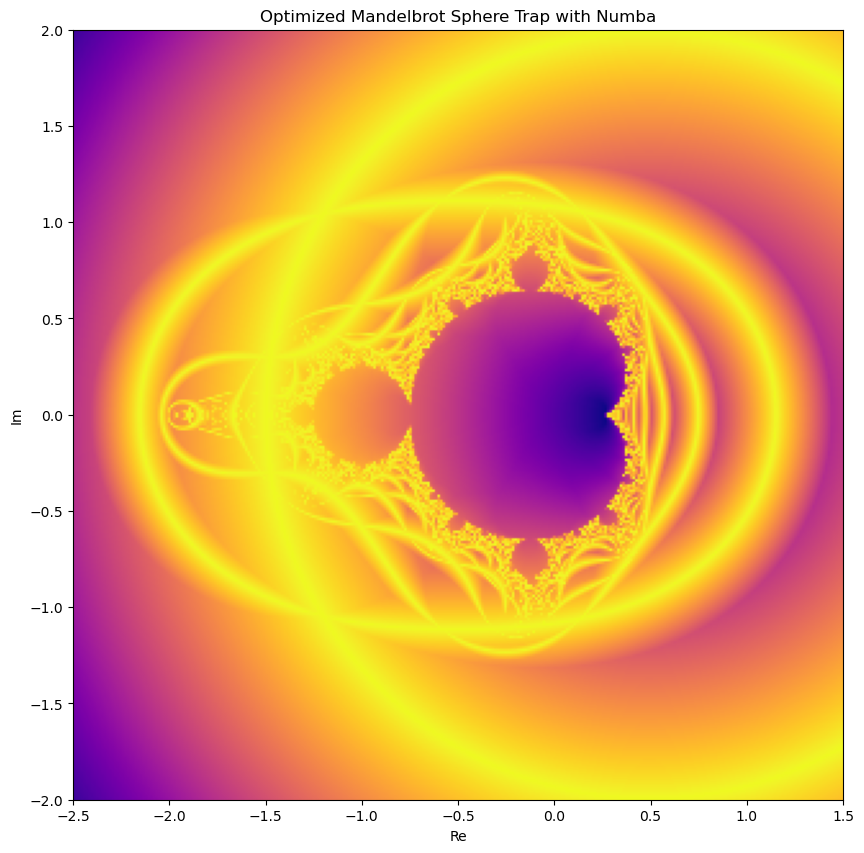

CPU times: user 1.83 s, sys: 320 ms, total: 2.15 s
Wall time: 723 ms


In [89]:
%%time

@numba.njit(parallel=True)
def mandelbrot_sphere_trap_optimized(x_min, x_max, y_min, y_max, width, height, max_iter,
                                     trap_center_real, trap_center_imag, trap_radius):
    trap_dist = np.full((height, width), np.inf)
    mask = np.ones((height, width), dtype=numba.boolean)
    
    # Coordinate grid (real and imaginary)
    xs = np.linspace(x_min, x_max, width)
    ys = np.linspace(y_min, y_max, height)
    
    # Complex trap center
    cx, cy = trap_center_real, trap_center_imag

    # Separate real and imag parts for Z
    Zr = np.zeros((height, width))
    Zi = np.zeros((height, width))

    for i in range(max_iter):
        for y in numba.prange(height):
            for x in range(width):
                if mask[y, x]:
                    # Manual complex multiplication: Z^2 = (a+bi)^2 = a² - b² + 2abi
                    zr, zi = Zr[y, x], Zi[y, x]
                    zr2, zi2 = zr*zr, zi*zi
                    Zi[y, x] = 2 * zr * zi + ys[y]
                    Zr[y, x] = zr2 - zi2 + xs[x]

                    # Distance to edge of trap circle
                    dx = Zr[y, x] - cx
                    dy = Zi[y, x] - cy
                    mag = np.sqrt(dx*dx + dy*dy)
                    dist = abs(mag - trap_radius)

                    if dist < trap_dist[y, x]:
                        trap_dist[y, x] = dist

                    if zr2 + zi2 >= 16:  # escape radius squared
                        mask[y, x] = False

    return trap_dist

width, height = res, res
#x_min, x_max = -2.5, 1.5
#y_min, y_max = -2, 2
max_iter = 300
#trap_center_real, trap_center_imag = 0.5, 0.0
#trap_radius = 3

trap_dist = mandelbrot_sphere_trap_optimized(x_min, x_max, y_min, y_max, width, height,
                                             max_iter, trap_center_real, trap_center_imag, trap_radius)

normalized = 1 - np.clip(trap_dist / trap_radius, 0, 1)

plt.figure(figsize=(10, 10))
plt.imshow(normalized, cmap='plasma', extent=(x_min, x_max, y_min, y_max))
plt.title("Optimized Mandelbrot Sphere Trap with Numba")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()